# Phase 3 Data Science Training Notebook

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import statistics as st
from functions import*

## Exploratory Data Analysis

In [2]:
folder='cifar-10-batches\\' # folder name that contains cifar-10 files
# training,test and name variables 
train_batch1=unpickle(folder+'data_batch_1')
test=unpickle(folder+'test_batch') 
label_names=unpickle(folder+'batches.meta')['label_names']


In [3]:
# display shape of dataset
ShapeOfData='variable: train_batch1 %s\n'%str(type(train_batch1))
ShapeOfData+='-------------------------------------\n'
ShapeOfData+=f'{"key": <13} size'+f'{"": <11}dtype\n' 
ShapeOfData+=f'{"---": <13} ----'+f'{"": <11}-----\n'
for key in train_batch1.keys():
    string=f'{key: <13} %s'%str(np.shape(train_batch1[key]))
    ShapeOfData+=f'{string: <29}%s'%str(type(train_batch1[key]))
    ShapeOfData+='\n'
print(ShapeOfData)

variable: train_batch1 <class 'dict'>
-------------------------------------
key           size           dtype
---           ----           -----
batch_label   ()             <class 'str'>
labels        (10000,)       <class 'list'>
data          (10000, 3072)  <class 'numpy.ndarray'>
filenames     (10000,)       <class 'list'>



In [4]:
# store training batches (1 to 5) in one variable
# reshape rgb data 2d (nx3072) array to 4d (nx32x32x3) for both test and training data
train_batches=[]
for num in range(1,6):
    dict=unpickle(folder+'data_batch_'+str(num))
    dict['data']=np.reshape(dict['data'],(10000,3,32,32))   
    dict['data']=np.transpose(dict['data'],[0,2,3,1])
    # remove keys that is unnecessary in this analysis
    dict.pop('batch_label')
    dict.pop('filenames')
    train_batches.append(dict)
# remove keys that is unnecessary in this analysis
test.pop('batch_label')
test.pop('filenames')
test['data']=np.reshape(test['data'],(10000,3,32,32))  
test['data']=np.transpose(test['data'],[0,2,3,1])

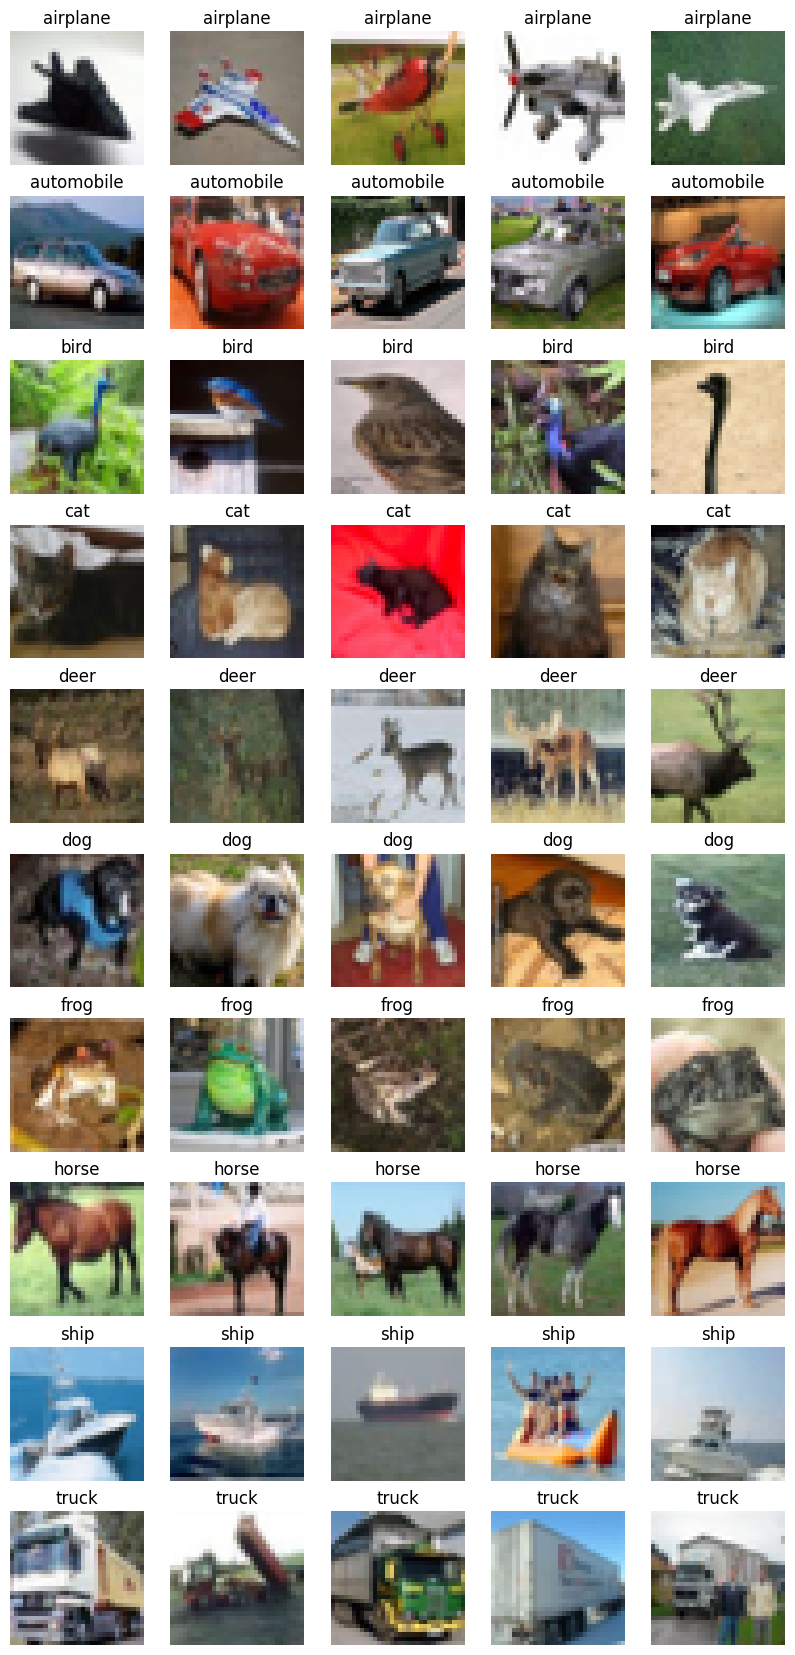

In [5]:
# render first 5 images in batch1 training set for each label
from PIL import Image
import matplotlib.pyplot as plt

train=train_batches[0]
num=0
plt.figure(figsize=(10, 21))
for label in range(10):
    for idx in np.where(np.array(train['labels'])==label)[0][0:5]:
        ax = plt.subplot(10, 5, num + 1)
        plt.imshow(train['data'][idx])
        plt.axis('off')  
        plt.title(label_names[label])  
        num+=1 

In [6]:
# label choice for the model
label_choice='automobile'

# Data Processing

In [7]:
# split training batches to label and image batches
train_images_batches = [train['data'] for train in train_batches]
train_labels_batches = np.array([train['labels'] for train in train_batches])
# combine batches to one batch
train_labels_combined=np.reshape(train_labels_batches,(50000))
train_images_combined=np.reshape(train_images_batches,(50000,32,32,3))
# get 10000 training and 2000 test samples
train_labels,train_images,test_labels,test_images=get_sample(train_labels_combined,train_images_combined,40000,test_set=10000)
validation_labels,validation_images=get_sample(np.array(test['labels']),test['data'],8000)

# Data Modelling

In [8]:
import tensorflow as tf
from tensorflow.keras import Input, layers, Sequential, optimizers, losses, callbacks

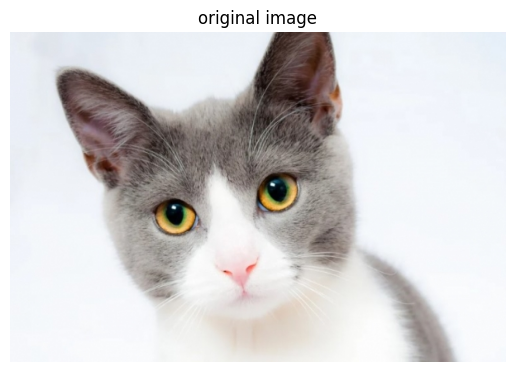

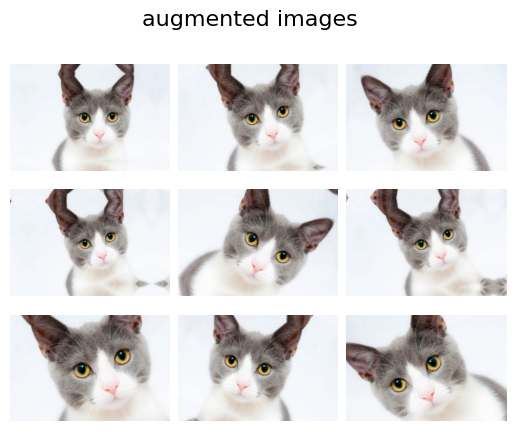

In [9]:
from tensorflow import keras
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.3),
])

from io import BytesIO
import requests
# get image by request
response=requests.get("http://www.chemicalnews.co.kr/news/photo/202106/3636_10174_4958.jpg")
img=Image.open(BytesIO(response.content))
# distplay original image
plt.imshow(img)
plt.title('original image')
img=np.array(img)
plt.axis("off")
# display augmented image
fig=plt.figure()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.suptitle('augmented images',fontsize=16)
for i in range(9):
  augmented_images = data_augmentation(tf.expand_dims(img, 0),training=True)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_images[0].numpy().astype("uint8"))
  plt.axis("off")

In [10]:
import IPython
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [11]:
import keras_tuner as kt
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=25,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
tuner.search(train_images, train_labels, epochs=50, validation_data=(validation_images,validation_labels), 
callbacks=[stop_early,ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal drop out ratio is {best_hps.get('dropout')}, the optimal number of units in the last densely-connected 
layer is {best_hps.get('units')} and the optimal learning rate for the optimizeris {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kt\tuner0.json
INFO:tensorflow:Oracle triggered exit

The optimal drop out ratio is 0.15, the optimal number of units in the last densely-connected 
layer is 192 and the optimal learning rate for the optimizeris 0.001.



In [12]:
tuner.search_space_summary(extended=False)
# get summary result for hyperparameter tuning
summary_dict=load_hyperParamSummary()

Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': None}
dropout (Choice)
{'default': 0.05, 'conditions': [], 'values': [0.05, 0.1, 0.15], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


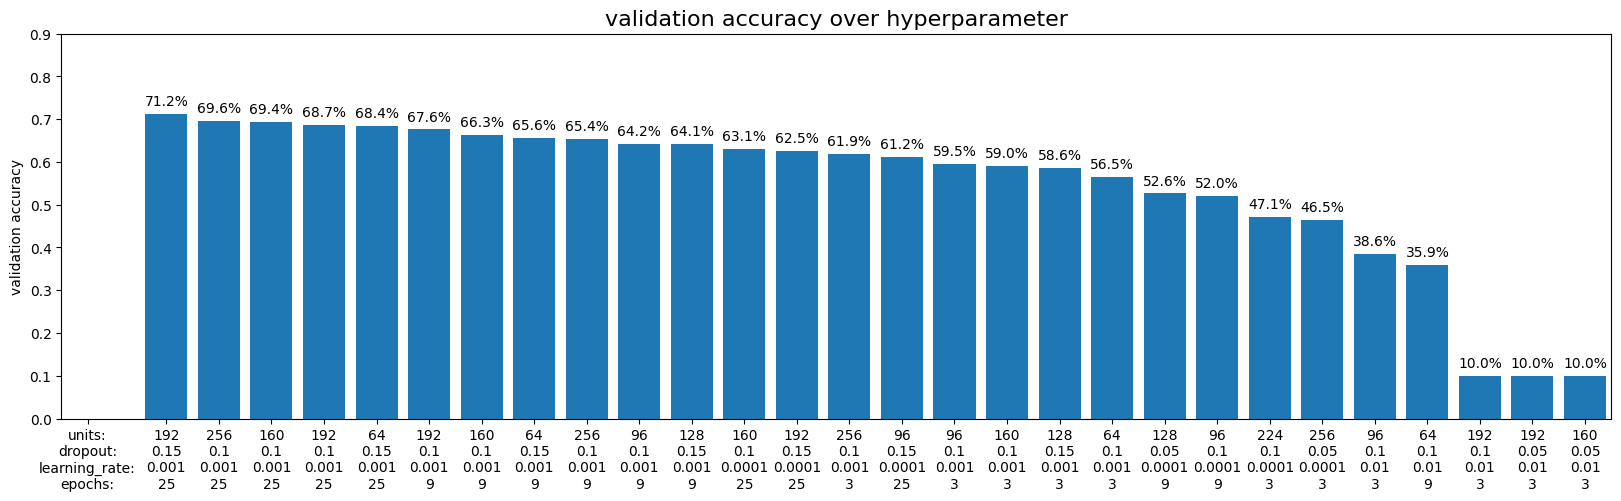

In [13]:
x=[i for i in range(2,30)]
plt.figure(figsize=(20,5))
plt.xticks([0.5]+x,['units:\ndropout:\nlearning_rate:\nepochs:']+summary_dict['combined'])
plt.bar([0.5]+x,[0]+summary_dict['Score'])
plt.xlim([0,29.5])
plt.ylim([0,.9])
for i in range(2,30):
    plt.text(i,summary_dict['Score'][i-2]+0.02,'{:.1f}%'.format(100*summary_dict['Score'][i-2]), ha = 'center',fontsize=10)
plt.title('validation accuracy over hyperparameter',fontsize=16)
plt.ylabel('validation accuracy')
plt.show()

In [14]:
import os.path
import json
# check the history alredy exist
if os.path.isfile('output\history'):
    #load the model
    history= json.load(open('output\history', 'r'))

    # print the result
    val_acc_per_epoch = history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,)) 
else:
    # Build the model with the optimal hyperparameters and train it on the data for 80 epochs
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(train_images, train_labels, epochs=80, validation_data=(validation_images,validation_labels))

    # save model
    # create directory and Save it under the form of a json file
    os.mkdir('output')
    json.dump(history.history, open('output\history', 'w'))
    
    # print the result
    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))    

Best epoch: 70


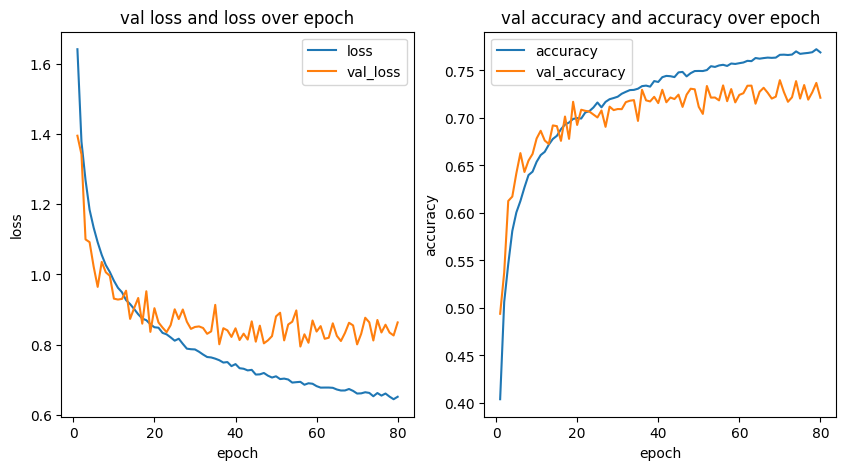

In [15]:
# plotting the result
t=np.linspace(1,80,80)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(t,history['loss'],label='loss')
ax1.plot(t,history['val_loss'],label='val_loss')
ax1.set_title('val loss and loss over epoch')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend()
ax2.plot(t,history['accuracy'],label='accuracy')
ax2.plot(t,history['val_accuracy'],label='val_accuracy')
ax2.set_title('val accuracy and accuracy over epoch')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend()
fig.set_figwidth(10)
fig.set_figheight(5)

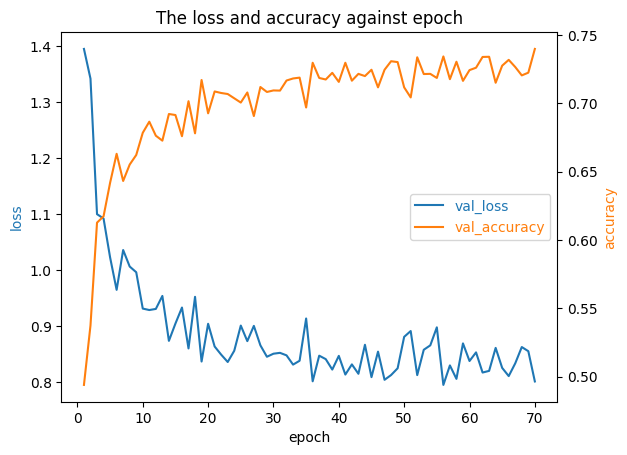

In [16]:
from mpl_toolkits.axes_grid1 import host_subplot
loss = host_subplot(111)
accuracy = loss.twinx()
plt.title('The loss and accuracy against epoch')
loss.set_xlabel("epoch")
loss.set_ylabel("loss")
accuracy.set_ylabel("accuracy")
p1, = loss.plot(t[0:70],(history['val_loss'])[0:70], label="val_loss")
p2, = accuracy.plot(t[0:70],(history['val_accuracy'])[0:70], label="val_accuracy")
leg = plt.legend()
loss.yaxis.get_label().set_color(p1.get_color())
leg.texts[0].set_color(p1.get_color())
accuracy.yaxis.get_label().set_color(p2.get_color())
leg.texts[1].set_color(p2.get_color())

In [17]:
# check if the model already exist
if os.path.isfile('output\my_model'):
    #load the model
    hypermodel = tf.keras.models.load_model('output\my_model')
else:
    # Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
    hypermodel = tuner.hypermodel.build(best_hps)

    # Retrain the model
    hypermodel.fit(train_images, train_labels, epochs=best_epoch)

    # save model
    hypermodel.save('output\my_model', save_format="h5")

In [18]:
hypermodel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (None, 32, 32, 3)         0         
                                                                 
 random_rotation_3 (RandomRo  (None, 32, 32, 3)        0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 32, 32, 3)         0         
                                                                 
 resizing_3 (Resizing)       (None, 32, 32, 3)         0         
                                                                 
 rescaling_3 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 16)        448       
                                                      

In [19]:
# result
eval_result = hypermodel.evaluate(validation_images, validation_labels)
print("[test loss, test accuracy]:", eval_result)

250/250 [==============================] - 3s 10ms/step - loss: 0.8277 - accuracy: 0.7374
[test loss, test accuracy]: [0.8277215361595154, 0.737375020980835]


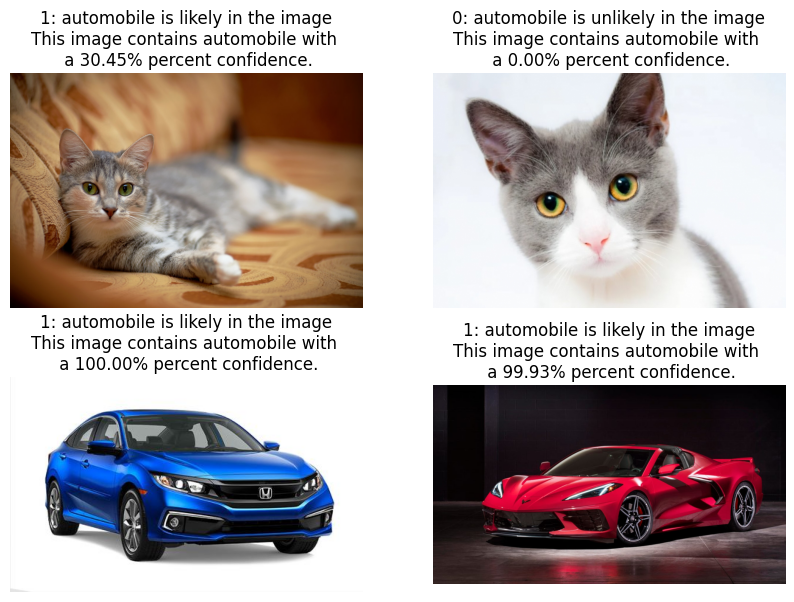

In [20]:
# if there is an image
if os.path.isfile('image/test.png')==False:
  img = Image.open('image/test.png')
  plt.figure(figsize=(10, 7))
  plt.axis('off')
  plt.imshow(img)
else:  
  # otherwise bring cat and automobile images and try on prediciton model
  img=[Image.open('image/cat0.png'),
  Image.open('image/cat1.png'),
  Image.open('image/car2.png'),
  Image.open('image/car3.png')
  ]
  plt.figure(figsize=(10, 7))
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    label,percent=predict(img[i])
    plt.imshow(img[i])
    plt.axis('off')
    # set up for titles on corresponding images
    if label:
      comment='is likely in the image'
    else:
      comment='is unlikely in the image'
    plt.title("{}: {} {}\nThis image contains {} with \n a {:.2f}% percent confidence."
        .format(label,label_choice,comment,label_choice,percent))
plt.show()        
     

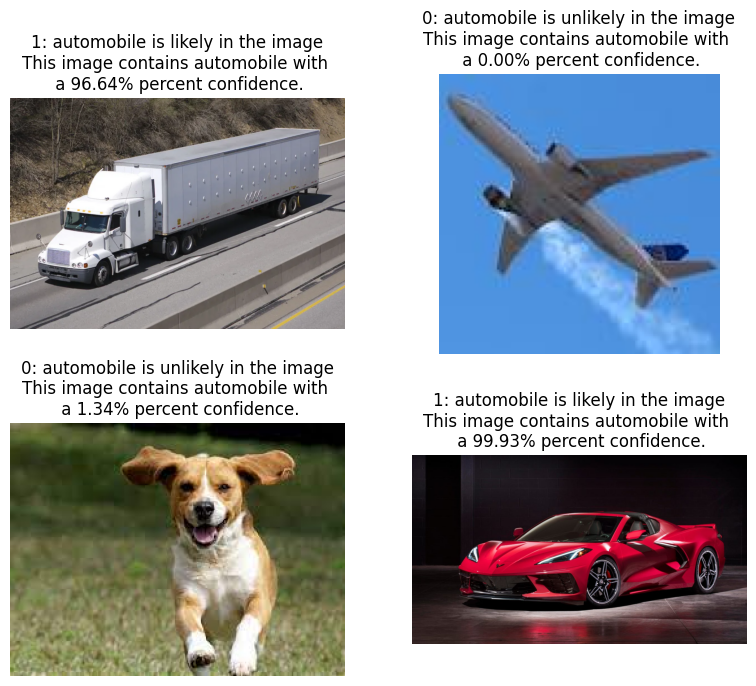

In [46]:
# otherwise bring cat and automobile images and try on prediciton model
img=[Image.open('image/truck.png'),
Image.open('image/airplane.png'),
Image.open('image/dog.png'),
Image.open('image/car3.png')
]
plt.figure(figsize=(9.5, 8))
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    label,percent=predict(img[i])
    plt.imshow(img[i])
    plt.axis('off')
    # set up for titles on corresponding images
    if label:
        comment='is likely in the image'
    else:
        comment='is unlikely in the image'
    plt.title("{}: {} {}\nThis image contains {} with \n a {:.2f}% percent confidence."
        .format(label,label_choice,comment,label_choice,percent))
plt.show()  

In [39]:
print('for validation images')
for weight in [0,10,20,30,40,50,60,70,80,90,100]:
    # calculation for 95 confidence interval
    label,percent=predict(validation_images,weight=weight)
    result=label==(validation_labels==1) # 1 indicate correct prediction
    percent=np.mean(result)
    interval=1.96*np.std(result)/np.sqrt(8000)
    print("{:.5f}% accuracy when weight is {}".format(percent,weight))

for validation images
0.95988% accuracy when weight is 0
0.95988% accuracy when weight is 10
0.95988% accuracy when weight is 20
0.96037% accuracy when weight is 30
0.96313% accuracy when weight is 40
0.96637% accuracy when weight is 50
0.97050% accuracy when weight is 60
0.97237% accuracy when weight is 70
0.97213% accuracy when weight is 80
0.96888% accuracy when weight is 90
0.90187% accuracy when weight is 100


In [23]:
# calculation for 95 confidence interval
label,percent=predict(test_images)
result=label==(test_labels==1) # 1 indicate correct prediction
percent=np.mean(result)
interval=1.96*np.std(result)/np.sqrt(8000)
print("95% confidence interval lie between {:.5f} and {:.5f}".format(percent-interval,percent+interval))
# for 95 confidence interval for biased input
print("when input with one type of images")
for i in range(10):
    test=test_images[np.where(test_labels==i)] # only one type of image is inputted
    label,percent=predict(test)
    if i==1:
        result=np.array(label)==1 #when inputted with automobile images
    else:
        result=np.array(label)!=1 #when inputted with images other than automobile images
    percent=np.mean(result)
    interval=1.96*np.std(result)/np.sqrt(8000)
    print("{:.5f} and {:.5f} for {} images".format(percent-interval,percent+interval,label_names[i]))

95% confidence interval lie between 0.95665 and 0.96515
when input with one type of images
0.96097 and 0.96903 for airplane images
0.88109 and 0.89491 for automobile images
0.97801 and 0.98399 for bird images
0.98343 and 0.98857 for cat images
0.99117 and 0.99483 for deer images
0.98782 and 0.99218 for dog images
0.97158 and 0.97842 for frog images
0.98561 and 0.99039 for horse images
0.92648 and 0.93752 for ship images
0.90476 and 0.91724 for truck images
